<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/003_TensorFlow_Proj_Three_FFNN_PolynomialCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# utils
from google.colab import drive
import itertools
import glob
import os, sys, shutil
import math
import numpy as np
import pandas as pd
from random import (randint, sample, choice)
from IPython.display import Image
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPool2D,
                                     AvgPool2D, Activation, Input,
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy,
                                      BinaryCrossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
# matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Set GPU
physical_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
print("No. GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)
# Mount google drive
drive.mount('/content/drive')

NameError: ignored

In [ ]:
# Curr dir
os.getcwd()

'/content'

In [ ]:
# Change dir
# os.chdir("drive/MyDrive/")

In [ ]:
# Create data set
def create_data(samples):
	points = []
	for i in range(samples):
		x = np.random.uniform(-5, 5)
		y = np.random.uniform(-5, 5)

		if -1 < x < 0:
			if y > math.sin(x) and y < x**2*math.sin(x):
				label = 0
			elif y < math.tan(x):
				label = 0
			elif y > math.log(x+7):
				label = 0
			else:
				label = 1

		if 0 < x < 1:
			if y < math.sin(x) and y > x**2*math.sin(x):
				label = 0
			elif y > math.tan(x) and y < math.log(x+7):
				label = 0
			else:
				label = 1

		if 1 < x < 2.858:
			if y > math.sin(x) and y < math.log(x+7):
				label = 0
			elif y > math.sin(x) and y > x**2*math.sin(x):
				label = 0
			elif y < math.tan(x):
				label = 0
			else:
				label = 1

		if -1 > x > -math.pi:
			if y < math.sin(x) and y > math.sin(x)*x**2:
				label=0
			elif y > math.tan(x) and y < math.log(x+7):
				label = 0
			else:
				label = 1

		if x > 2.858:
			if y > math.sin(x)*x**2 and y > math.tan(x) and y < math.log(x+7):
				label = 1
			else:
				label = 0

		if x < -math.pi:
			if y > math.sin(x) and y < math.log(x+7) and y < math.sin(x)*x**2:
				label = 1
			elif y < math.tan(x):
				label = 1
			elif y > math.log(x+7) and y < math.sin(x):
				label = 1
			else:
				label = 0

		points.append([x,y,label])

	df = pd.DataFrame(np.array(points), columns=['x','y','color'])

	return df

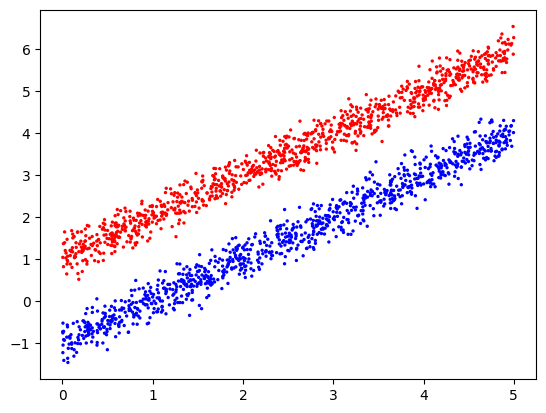

          x         y color
0  3.574100  4.576872   red
1  3.475047  4.061416   red
2  1.922728  3.189368   red
3  0.517000  1.477122   red
4  2.677949  3.815203   red
Epoch 1/40
400/400 [==============================] - 7s 14ms/step - loss: 0.6209 - accuracy: 0.9120
Epoch 2/40
400/400 [==============================] - 3s 7ms/step - loss: 0.5892 - accuracy: 0.8635
Epoch 3/40
400/400 [==============================] - 1s 3ms/step - loss: 0.5630 - accuracy: 0.8335
Epoch 4/40
400/400 [==============================] - 3s 7ms/step - loss: 0.5376 - accuracy: 0.8490
Epoch 5/40
400/400 [==============================] - 2s 3ms/step - loss: 0.5125 - accuracy: 0.8595
Epoch 6/40
400/400 [==============================] - 2s 4ms/step - loss: 0.4873 - accuracy: 0.9040
Epoch 7/40
400/400 [==============================] - 2s 5ms/step - loss: 0.4615 - accuracy: 0.9265
Epoch 8/40
400/400 [==============================] - 1s 3ms/step - loss: 0.4337 - accuracy: 0.9425
Epoch 9/40
400/400 [===========

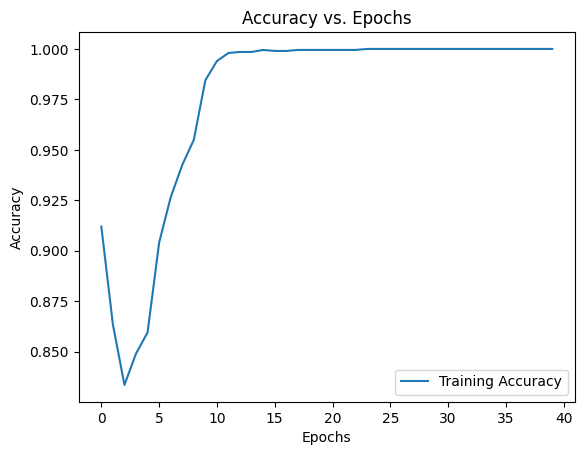

In [ ]:
# Gen sample
def bi_linear(samples):
  # Red points
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue points
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Stack and return df
  final= np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])

# Define colors
color_dict = {0: 'red', 1: 'blue'}
# Train df
n_train =1000
train_df = bi_linear(n_train)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
n_test = 200
test_df = bi_linear(n_test)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'linear'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

# Plot
plt.figure()
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
plt.show()
# Shuffle
np.random.shuffle(train_df.values)
# Print
print(train_df.head())
# Shallow N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# Complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# Stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# Fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40)
# # Evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

          x         y color
0  4.275576  5.316428   red
1  4.377526  5.600351   red
2  1.590385  2.828100   red
3  4.324160  5.372163   red
4  4.564282  5.725146   red
Epoch 1/40
600/600 [==============================] - 6s 6ms/step - loss: 1.1164 - accuracy: 0.3957
Epoch 2/40
600/600 [==============================] - 3s 5ms/step - loss: 0.8320 - accuracy: 0.7063
Epoch 3/40
600/600 [==============================] - 2s 4ms/step - loss: 0.6666 - accuracy: 0.7407
Epoch 4/40
600/600 [==============================] - 3s 5ms/step - loss: 0.5703 - accuracy: 0.7723
Epoch 5/40
600/600 [==============================] - 2s 4ms/step - loss: 0.4910 - accuracy: 0.8540
Epoch 6/40
600/600 [==============================] - 4s 6ms/step - loss: 0.4096 - accuracy: 0.9190
Epoch 7/40
600/600 [==============================] - 4s 6ms/step - loss: 0.3363 - accuracy: 0.9450
Epoch 8/40
600/600 [==============================] - 4s 7ms/step - loss: 0.2737 - accuracy: 0.9590
Epoch 9/40
600/600 [============

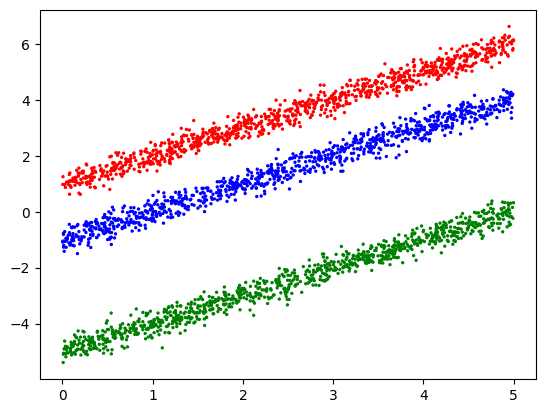

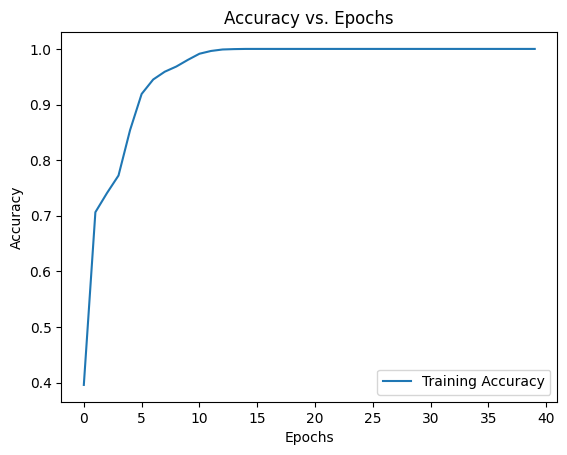

In [ ]:
def three_lines(samples):
  # Red
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Green
  x3 = np.random.uniform(0,5,samples)
  y3 = x3 - np.random.normal(5,0.25, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # Stack and return
  final= np.row_stack((red,blue,green))
  return pd.DataFrame(final, columns=['x','y','color'])
# Color code
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
# Train df
train_df = three_lines(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = three_lines(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'linear_multigroup'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)
# Plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
# Shuffle
np.random.shuffle(train_df.values)
# Print
print(train_df.head())
# Deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(3, activation="softmax")])
# Complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="categorical_crossentropy",
	          metrics=['accuracy'])
# Stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=False).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=False).values
# Fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40)
# # Evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

          x          y color
0  0.600023   2.248529   red
1 -4.011007  17.491152   red
2 -1.359434   3.779227   red
3 -4.014638  17.606152   red
4 -0.241468   1.367810   red
Epoch 1/40
400/400 [==============================] - 7s 12ms/step - loss: 0.6638 - accuracy: 0.6955
Epoch 2/40
400/400 [==============================] - 3s 7ms/step - loss: 0.6307 - accuracy: 0.6990
Epoch 3/40
400/400 [==============================] - 3s 7ms/step - loss: 0.5904 - accuracy: 0.6940
Epoch 4/40
400/400 [==============================] - 2s 4ms/step - loss: 0.5558 - accuracy: 0.7225
Epoch 5/40
400/400 [==============================] - 2s 4ms/step - loss: 0.5243 - accuracy: 0.7495
Epoch 6/40
400/400 [==============================] - 2s 6ms/step - loss: 0.4949 - accuracy: 0.7880
Epoch 7/40
400/400 [==============================] - 4s 9ms/step - loss: 0.4680 - accuracy: 0.8220
Epoch 8/40
400/400 [==============================] - 2s 4ms/step - loss: 0.4404 - accuracy: 0.8510
Epoch 9/40
400/400 [=====

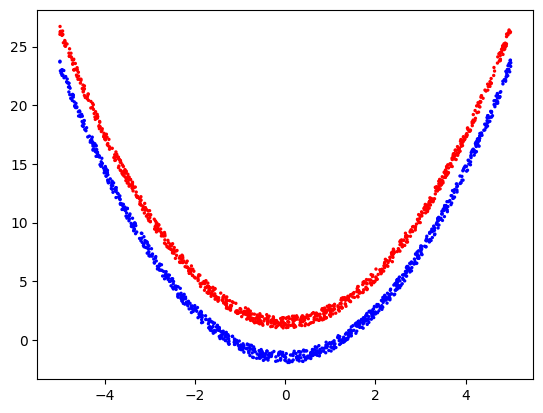

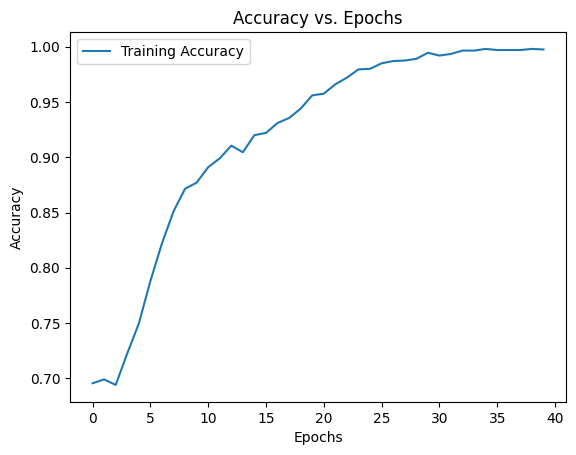

In [ ]:
def quadratic(samples):
  # Red
  x1 = np.random.uniform(-5,5, samples)
  y1 = x1**2 + np.random.uniform(1,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(-5,5,samples)
  y2 = x2**2 - np.random.uniform(1,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Stack and return
  final = np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue'}
# Train df
train_df = quadratic(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = quadratic(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'quadratic'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)
# Plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
# Shuffle
np.random.shuffle(train_df.values)
# Print
print(train_df.head())
# Deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# Complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# Stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# Fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40               )
# Evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

          x         y  color
0 -0.660504  0.566854      0
1 -0.574225  0.614580      0
2 -0.850664  1.815597      0
3 -0.133860  0.791741      0
4 -0.311879  1.489670      0
[0 1 2 3 4 5]
Epoch 1/30
1200/1200 [==============================] - 13s 9ms/step - loss: 0.6326 - accuracy: 0.7698
Epoch 2/30
1200/1200 [==============================] - 17s 14ms/step - loss: 0.1749 - accuracy: 0.9522
Epoch 3/30
1200/1200 [==============================] - 11s 10ms/step - loss: 0.1235 - accuracy: 0.9647
Epoch 4/30
1200/1200 [==============================] - 11s 9ms/step - loss: 0.1006 - accuracy: 0.9692
Epoch 5/30
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0908 - accuracy: 0.9687
Epoch 6/30
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0854 - accuracy: 0.9702
Epoch 7/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0743 - accuracy: 0.9738
Epoch 8/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0713 - accurac

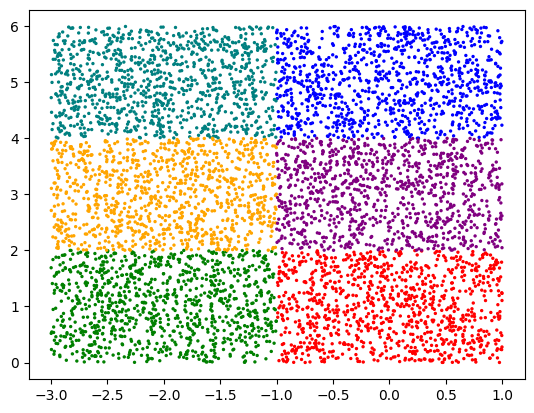

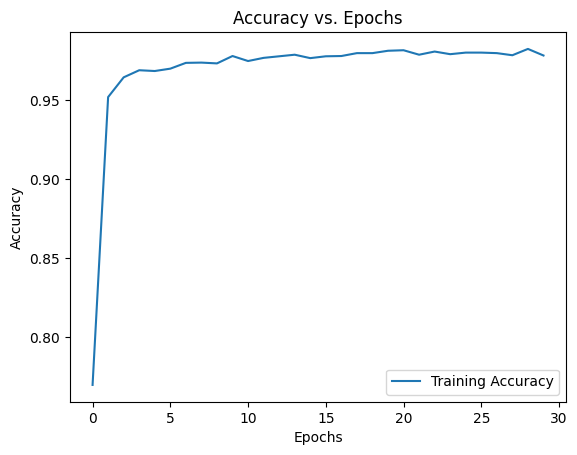

In [ ]:
def clusters(samples):
  # Red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # Teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  teal = np.column_stack((x4,y4,z4))
  # Orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  orange = np.column_stack((x5,y5,z5))
  # Purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  purple = np.column_stack((x6,y6,z6))
  # Stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color'])
# Color code
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
# Train df
train_df = clusters(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = clusters(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save frames
graph = 'clusters_multi_categories'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)
# Plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
# Enumerate colors
color_dict = {'red': 0, 'blue': 1, 'green': 2, 'teal': 3, 'orange': 4, 'purple': 5}
train_df['color'] = train_df.color.apply(lambda x: color_dict[x])
# Shuffle
np.random.shuffle(train_df.values)
# Print
print(train_df.head())
print(train_df.color.unique())
# Model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(6, activation='softmax')])
# Compile
model.compile(optimizer='adam',
	          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# Stack features
train_x = np.column_stack((train_df.x.values, train_df.y.values))
test_x = np.column_stack((test_df.x.values, test_df.y.values))
# Fit
hist = model.fit(train_x, train_df.color.values, batch_size=5, epochs=30)
# Evaluate
print("EVALUATION")
test_df['color'] = test_df.color.apply(lambda x: color_dict[x])
model.evaluate(test_x, test_df.color.values)
print("Prediction", np.round(model.predict(np.array([[0,3]]))))
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

Epoch 1/40
600/600 [==============================] - 5s 5ms/step - loss: 0.4563 - accuracy: 0.0617
Epoch 2/40
600/600 [==============================] - 4s 7ms/step - loss: 0.2853 - accuracy: 0.1292
Epoch 3/40
600/600 [==============================] - 3s 5ms/step - loss: 0.2302 - accuracy: 0.1952
Epoch 4/40
600/600 [==============================] - 3s 4ms/step - loss: 0.2053 - accuracy: 0.2720
Epoch 5/40
600/600 [==============================] - 2s 4ms/step - loss: 0.1838 - accuracy: 0.3170
Epoch 6/40
600/600 [==============================] - 2s 3ms/step - loss: 0.1707 - accuracy: 0.3242
Epoch 7/40
600/600 [==============================] - 5s 9ms/step - loss: 0.1569 - accuracy: 0.2998
Epoch 8/40
600/600 [==============================] - 2s 3ms/step - loss: 0.1517 - accuracy: 0.3283
Epoch 9/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1436 - accuracy: 0.3207
Epoch 10/40
600/600 [==============================] - 3s 5ms/step - loss: 0.1387 - accuracy: 0.3183

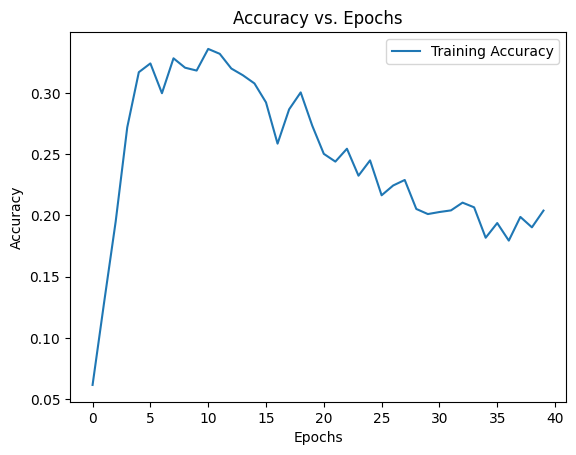

In [ ]:
def clusters_advanced(samples):
  # Red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # Blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # Green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # Teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # Orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # Purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # Stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])
# Color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}
# Train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# Test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# Save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)
# One hot encoders
# Train
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
# Test
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# Stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# Model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.4),
 	keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(16, activation='relu'),
  keras.layers.Dropout(0.4),
	keras.layers.Dense(9, activation='sigmoid')])
# Compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# Stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))
# Shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)
# Fit
hist = model.fit(x, train_labels, batch_size=10, epochs=40)
# Evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))
# Plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

Epoch 1/10
300/300 [==============================] - 3s 7ms/step - loss: 0.3839 - accuracy: 0.1638
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.1794 - accuracy: 0.3160
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.1212 - accuracy: 0.4102
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0783 - accuracy: 0.3933
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.3375
Epoch 6/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0478 - accuracy: 0.3155
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0398 - accuracy: 0.3015
Epoch 8/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0367 - accuracy: 0.2820
Epoch 9/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0335 - accuracy: 0.2632
Epoch 10/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0312 - accuracy: 0.2587

1/1 [==============================] - 1s 641ms/step
Prediction [[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


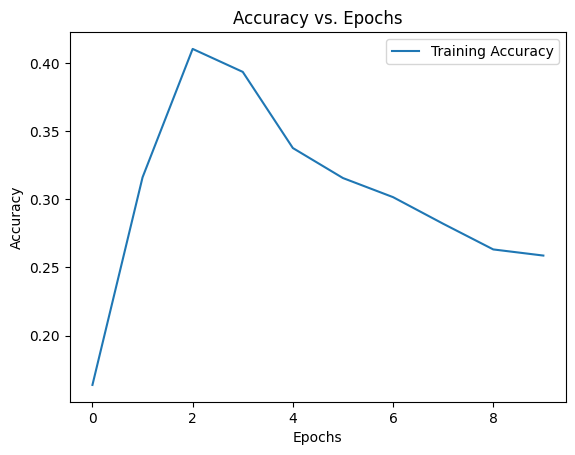

In [ ]:
def clusters_advanced(samples):
  # Red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # Blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # Green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # Teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # Orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # Purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # Stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])
# Color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}
# Train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# Test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# Save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)
# One hot encoders
# Train
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
# Test
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# Stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# Model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(9, activation='softmax')])
# Compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# Stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))
# Shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)
# Fit
hist = model.fit(x, train_labels, batch_size=20, epochs=10)
# Evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))
# Plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()